<a href="https://colab.research.google.com/github/UzuiRoarGITS/Speech_Emotion_Recognition/blob/main/Speech_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240923%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240923T185950Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D737076aa32b9839d038265948dab75e5a24dfeb078f7e7106cb93b1e6522ee56f49bdf6a9caebce6d072c7460e4c31b224827328ce74d164dd57dfa39dca8605151fe0ed63a631e9c9e42db502c392a69e83445830fd97b013461fada2e7f9efc3f49605f69b805ea41f2183f9d87c00378952a74142c377d8c6873bd0a018ab364165f81c66e479112b8f3c9414310f86d95ec852860eec6533e873f760ce5e60166537d1b7da45e8398623fc9cf7ed81e586976bd2c8445b9bbc08798cadcc0af624ea642e09794b2f167c25d068f5f21108c942e43ad2ed6ec63a6f2858e82d6cbe039962ff8086262b9f1dd4b7105a01900f56339cb5bf00ea4d01aace71'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
Data source import complete.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

**IMPORT MODULES**


In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')


**LOAD DATASET**

In [4]:
paths = []
labels= []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label=filename.split('_')[-1]
        label=label.split('.')[0]
        labels.append(label.lower())
        break

print('Dataset loaded')

Dataset loaded


In [5]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_wire_happy.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_pearl_angry.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_ditch_ps.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_mob_disgust.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_happy/YAF_south_happy.wav']

In [6]:
labels[:5]

['happy', 'angry', 'ps', 'disgust', 'happy']

In [7]:
##data frame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,happy
1,/kaggle/input/toronto-emotional-speech-set-tes...,angry
2,/kaggle/input/toronto-emotional-speech-set-tes...,ps
3,/kaggle/input/toronto-emotional-speech-set-tes...,disgust
4,/kaggle/input/toronto-emotional-speech-set-tes...,happy


In [8]:
df['label'].value_counts()


,count
label,
happy,4
angry,4
ps,4
disgust,4
neutral,4
sad,4
fear,4


## Data Analysis

<Axes: ylabel='count'>

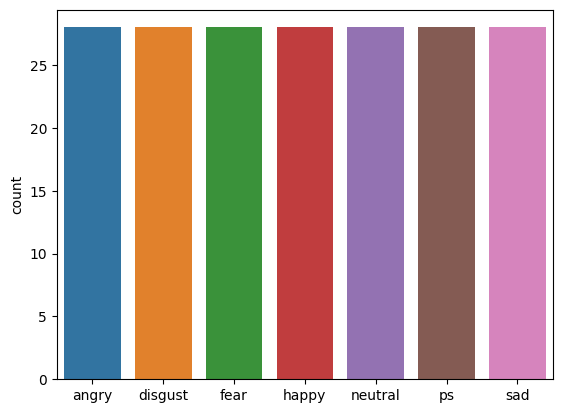

In [9]:
one_hot_encoded = pd.get_dummies(df['label'])
sns.countplot(data=one_hot_encoded)

In [10]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20 )
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()



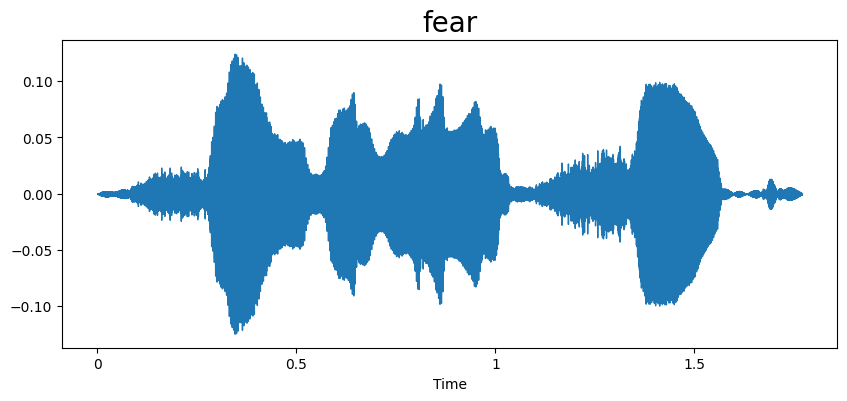

In [30]:
emotion='fear'
path=np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
Audio(path)

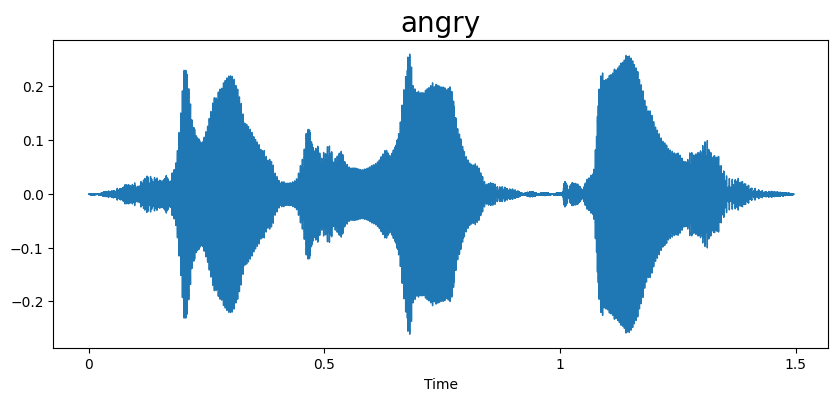

In [12]:
emotion='angry'
path=np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
Audio(path)

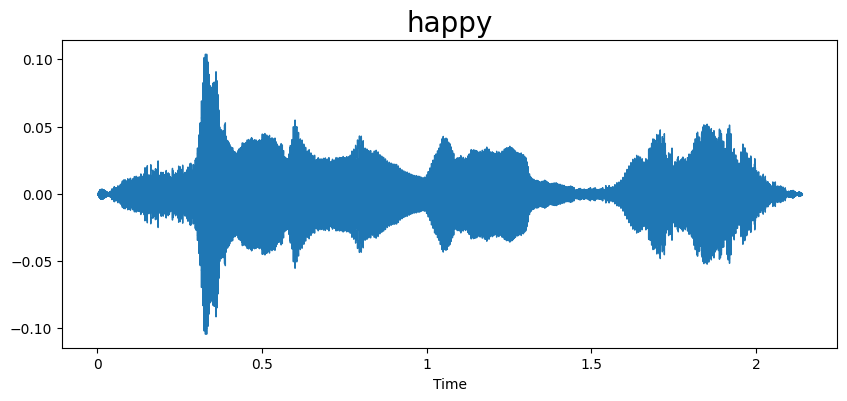

In [13]:
emotion='happy'
path=np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
Audio(path)

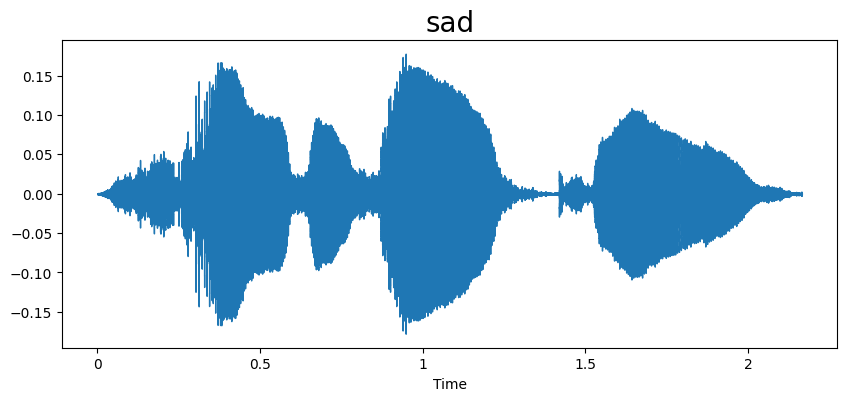

In [14]:
emotion='sad'
path=np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
Audio(path)

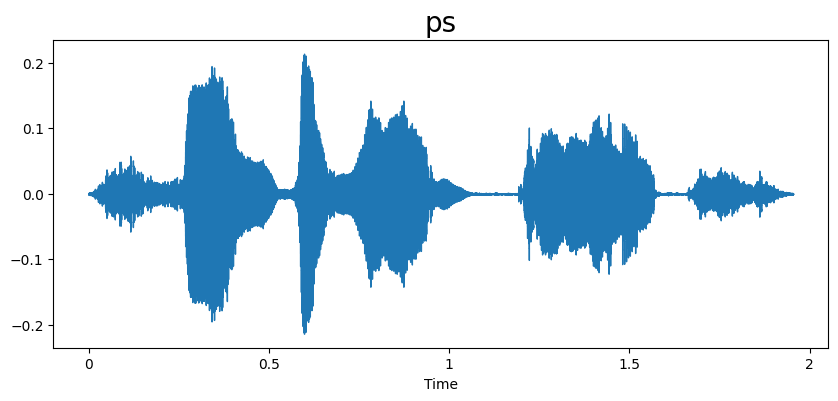

In [15]:
emotion='ps'
path=np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
Audio(path)

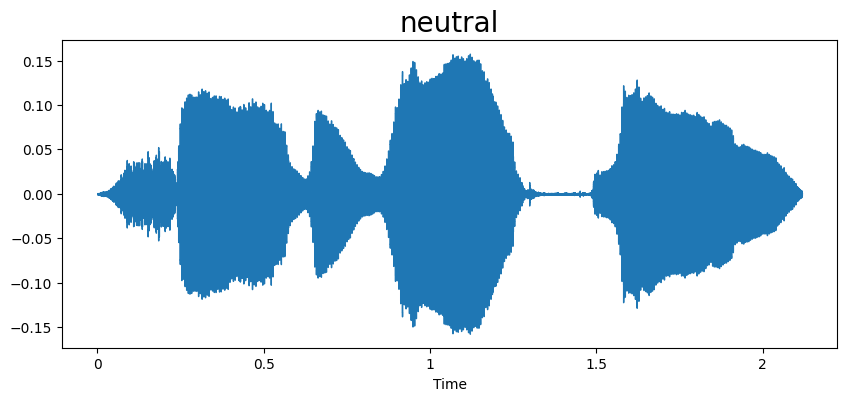

In [31]:
emotion='neutral'
path=np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
Audio(path)

# Feature Extraction

In [17]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)

    return mfcc



In [18]:
extract_mfcc(df['speech'][0])

array([-4.83021179e+02,  1.33152267e+02,  1.44370270e+01, -1.14514437e+01,
        2.43912387e+00,  1.98965669e+00, -1.32553043e+01, -1.18671846e+01,
       -1.36389990e+01, -4.39005661e+00, -1.28775845e+01, -7.15477037e+00,
       -6.92891026e+00, -2.75636959e+00, -2.09642744e+00,  6.84235275e-01,
       -1.09001505e+00,  6.50658512e+00,  1.61044466e+00, -6.36313725e+00,
        2.35070243e-01,  1.23113656e+00,  3.30840975e-01,  1.06179199e+01,
       -2.75096804e-01,  7.92355633e+00,  8.22293088e-02,  5.89745045e+00,
       -3.11818457e+00,  9.81580639e+00, -7.99484313e-01,  6.21155739e+00,
        9.85491574e-01,  2.77009058e+00,  4.53815174e+00,  9.99483871e+00,
        9.46591091e+00,  1.00070715e+01,  8.99196148e+00,  1.10007620e+01],
      dtype=float32)

In [19]:
X_mfcc=df['speech'].apply(lambda x: extract_mfcc(x))


In [20]:
X_mfcc

,speech
0,"[-483.02118, 133.15227, 14.437027, -11.451444,..."
1,"[-416.87918, 103.68762, 11.017201, -33.429592,..."
2,"[-384.38004, 31.405188, -10.559107, 21.58392, ..."
3,"[-474.39954, 142.18642, 34.14589, -14.836807, ..."
4,"[-322.72653, 48.806816, -15.4125, 15.4176855, ..."
5,"[-440.1046, 74.91491, -3.7593958, 29.432064, -..."
6,"[-402.7426, 92.841805, -12.85219, 20.528704, -..."
7,"[-412.27554, 93.48096, 27.504713, 27.473764, -..."
8,"[-434.9357, 43.04546, -0.8202808, 15.13638, 7...."
9,"[-532.05756, 91.40163, 17.907005, 6.8987823, 1..."


In [21]:
X=[x for x in X_mfcc]
X=np.array(X)
X.shape

(28, 40)

In [22]:
X=np.expand_dims(X,-1)
print(X.dtype)
X.shape

float32


(28, 40, 1)

In [23]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y =enc.fit_transform(df[['label']])

In [24]:
y = y.toarray()

In [25]:
y.shape


(28, 7)

# LSTM MODEL

In [26]:
from keras.models import Sequential
from keras.layers import Dense ,LSTM, Dropout
model= Sequential([
    LSTM(123,return_sequences=False , input_shape=(40,1)),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(32,activation='relu'),
    Dropout(0.2),
    Dense(7,activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 123)                 │          61,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,747 (280.26 KB)

 Trainable params: 71,747 (280.26 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(X, y, validation_split=0.2, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1818 - loss: 1.9805 - val_accuracy: 0.1667 - val_loss: 1.9241
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0909 - loss: 1.9345 - val_accuracy: 0.1667 - val_loss: 1.9093
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1364 - loss: 1.9245 - val_accuracy: 0.1667 - val_loss: 1.8946
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.1818 - loss: 1.8889 - val_accuracy: 0.1667 - val_loss: 1.8806
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1818 - loss: 1.8814 - val_accuracy: 0.1667 - val_loss: 1.8636
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2273 - loss: 1.8501 - val_accuracy: 0.1667 - val_loss: 1.8428
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3636 - loss: 1.8097 - val_accuracy: 0.1667 - val_loss: 1.8206
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2273 - loss: 1.8270 - val_accuracy: 0.1667 - val_

# PLOT RESULTS

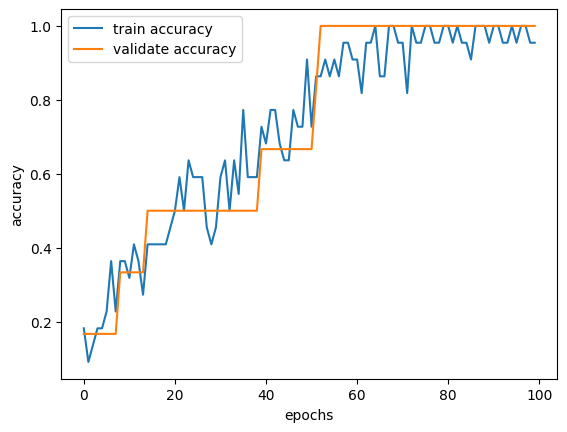

In [28]:
epochs=list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs,acc,label='train accuracy')
plt.plot(epochs,val_acc,label='validate accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


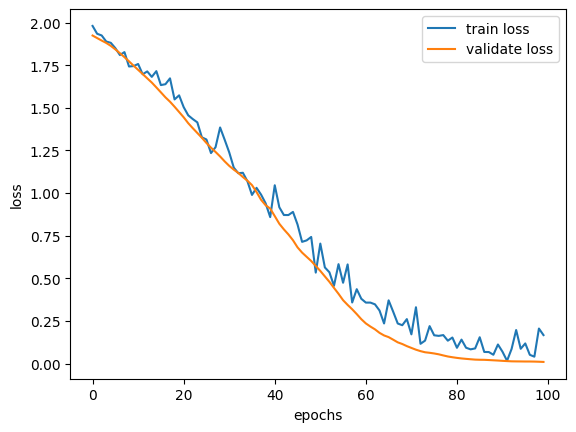

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs,loss,label='train loss')
plt.plot(epochs,val_loss,label='validate loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
